## XGBoost

The feature engineered random forest performed better than the decision tree! 

In this notebook, I will try the XGBoost classifier model to see if it performs better than the random forest.

In [2]:
path = './playground-series-s5e8'

In [3]:
import numpy as np, pandas as pd, os
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./playground-series-s5e8/test.csv
./playground-series-s5e8/train.csv
./playground-series-s5e8/sample_submission.csv


In [2]:
from fastai.imports import *
np.set_printoptions(linewidth=130)

## Looking at the data

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv(f'{path}/train.csv')
df

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1
749996,749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0
749997,749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0
749998,749998,32,technician,married,secondary,no,-274,no,no,cellular,26,aug,108,6,-1,0,unknown,0


In [5]:
df.isna().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

There are no missing values (at least no NaNs).

In [6]:
df['y'].value_counts()

y
0    659512
1     90488
Name: count, dtype: int64

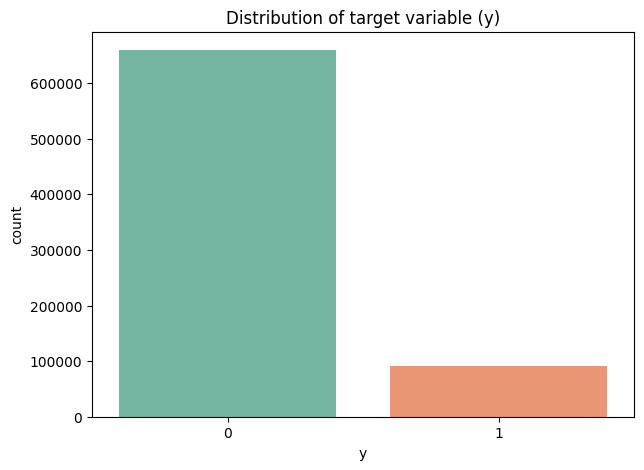

In [7]:
plt.figure(figsize=(7,5));

sns.countplot(data=df, x='y', palette='Set2')
plt.title('Distribution of target variable (y)')
plt.show()

## Continuous variables

In [8]:
df.describe(include='number')

,id,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,216506.495284,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,0.000000,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,187499.750000,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,374999.500000,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,562499.250000,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,749999.000000,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


```id``` is a unique value for each row/sample, so don't have to take that into consideration. ```y``` is the dependent variable.

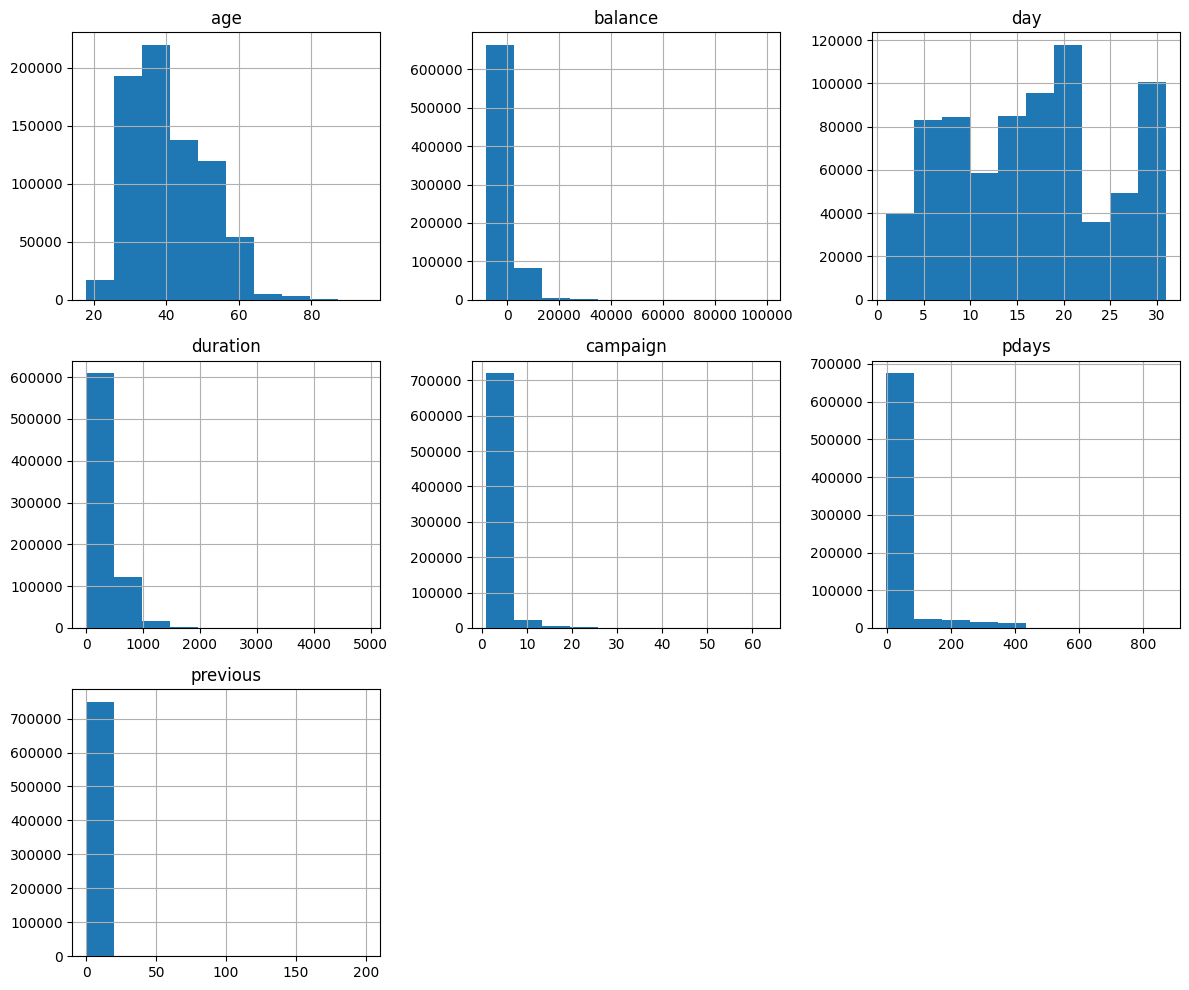

In [9]:
df_to_plot = df.select_dtypes(include='number').drop(columns=['id', 'y'])

df_to_plot.hist(figsize=(12,10));
plt.tight_layout()
plt.show()

```balance``` and ```duration``` are very right-skewed.

In [10]:
df.pdays.value_counts()

pdays
-1      672434
 182      2515
 92       2275
 183      2074
 181      1698
         ...  
 647         1
 614         1
 420         1
 735         1
 20          1
Name: count, Length: 596, dtype: int64

A ```pdays``` entry of -1 indicates that the client has never been contacted before.

In [11]:
df.previous.nunique()

50

Looking at correlations between the continuous variables and the target:

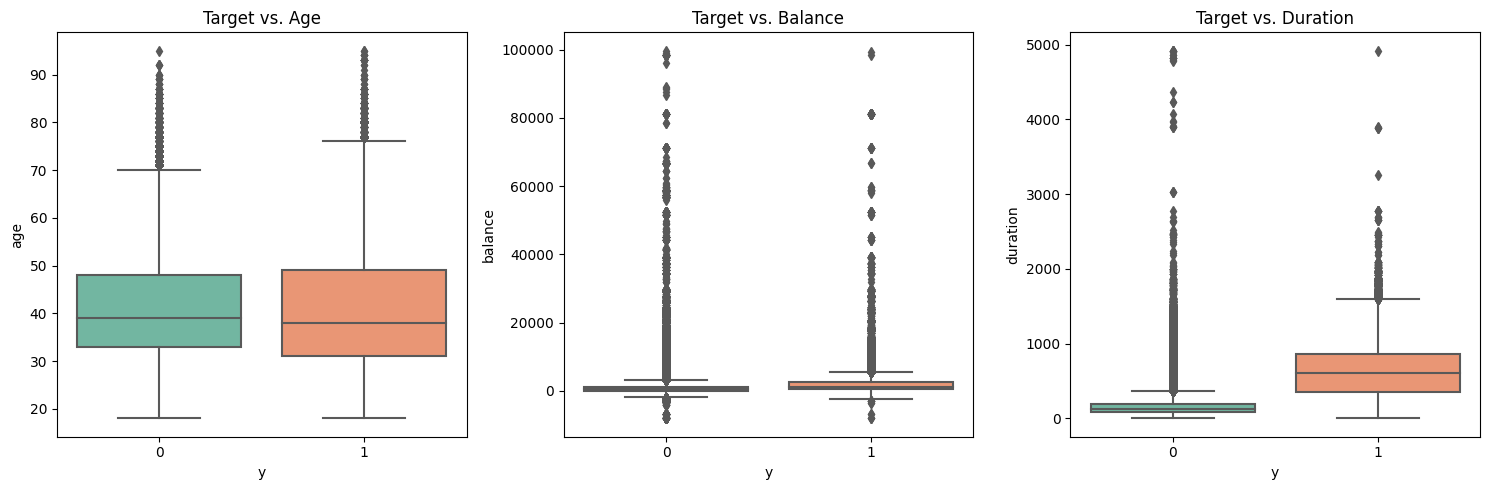

In [12]:
cont_cols = ['age','balance','duration']

plt.figure(figsize=(15,5));

for i, colname in enumerate(cont_cols,1):
    plt.subplot(1,3,i)
    sns.boxplot(x='y', y=colname, data=df, palette='Set2');
    plt.title(f'Target vs. {colname.capitalize()}')

plt.tight_layout()
plt.show()

Out of these 3 variables, last call duration shows the most correlation with target.

## Categorical variables

In [13]:
df.describe(include=[object])

,job,marital,education,default,housing,loan,contact,month,poutcome
count,750000,750000,750000,750000,750000,750000,750000,750000,750000
unique,12,3,4,2,2,2,3,12,4
top,management,married,secondary,no,yes,no,cellular,may,unknown
freq,175541,480759,401683,737151,411288,645023,486655,228411,672450


Looks like some of the categorical columns contain a category called 'unknown'. Specifically, the ```contact``` and ```poutcome``` columns contain this value.

In [14]:
cat_cols = ['job','marital','education','default','housing','loan','contact','month','poutcome']
cont = ['age','balance','day','duration','campaign','pdays','previous']
dep = 'y'

In [15]:
for col in cat_cols:
    print(df[col].unique())

['technician' 'blue-collar' 'student' 'admin.' 'management' 'entrepreneur' 'self-employed' 'unknown' 'services' 'retired'
 'housemaid' 'unemployed']
['married' 'single' 'divorced']
['secondary' 'primary' 'tertiary' 'unknown']
['no' 'yes']
['no' 'yes']
['no' 'yes']
['cellular' 'unknown' 'telephone']
['aug' 'jun' 'may' 'feb' 'apr' 'nov' 'jul' 'jan' 'oct' 'mar' 'sep' 'dec']
['unknown' 'other' 'failure' 'success']


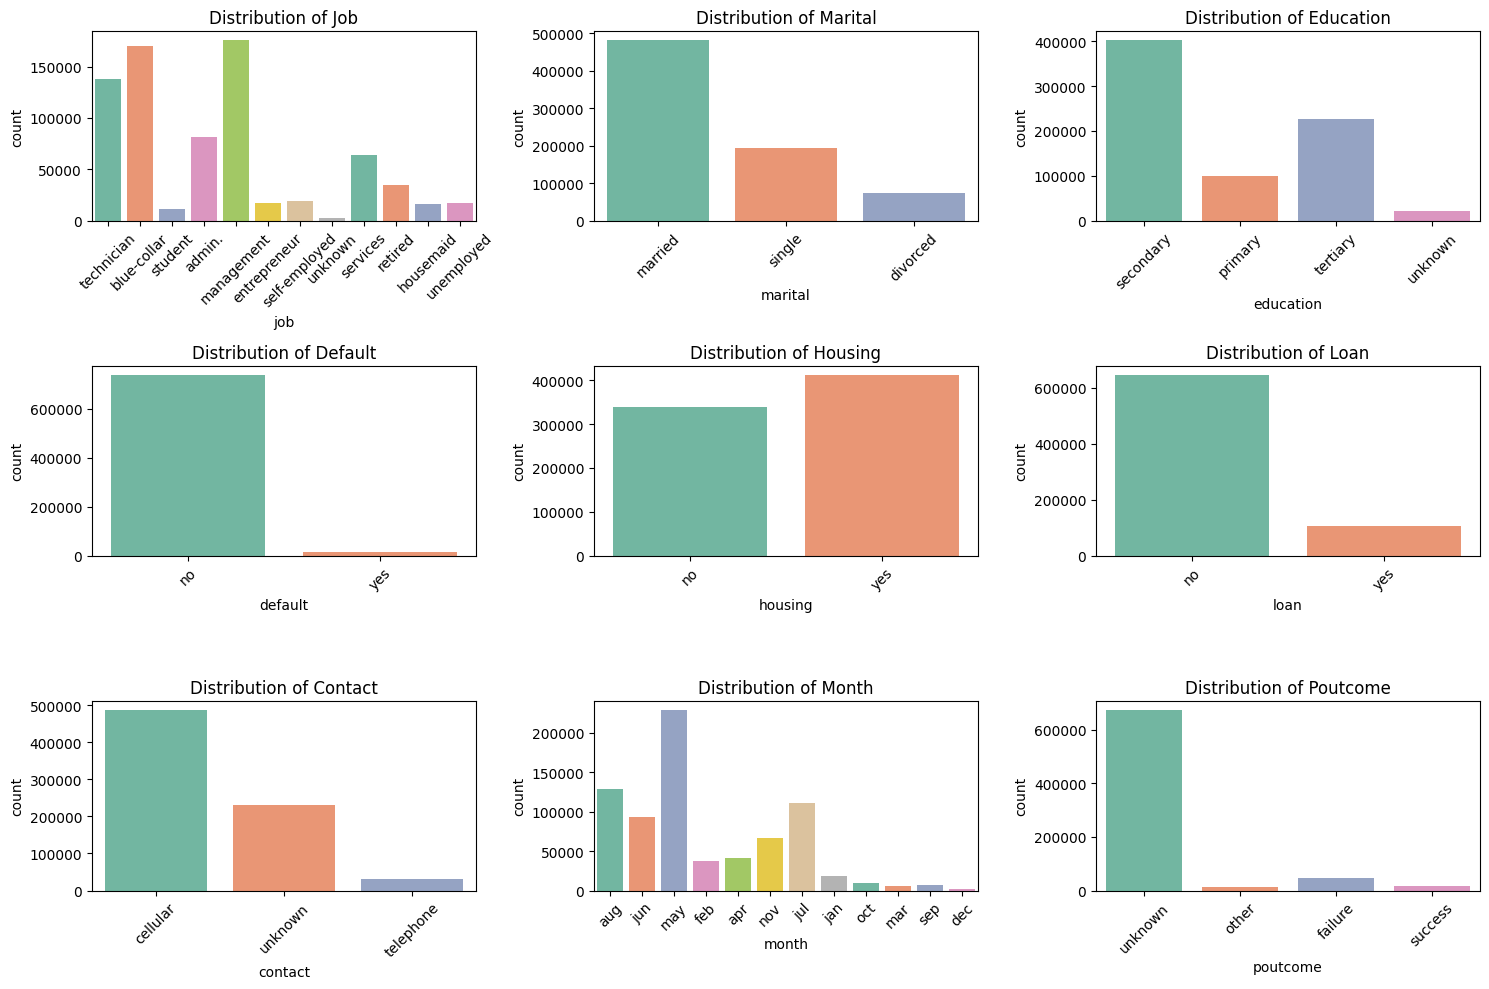

In [16]:
plt.figure(figsize=(15,10))

for i,colname in enumerate(cat_cols,1):
    plt.subplot(3,3,i)
    sns.countplot(data=df, x=colname, palette='Set2');
    plt.title(f'Distribution of {colname.capitalize()}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
df['month']

0         aug
1         jun
2         may
3         may
4         feb
         ... 
749995    jul
749996    aug
749997    apr
749998    aug
749999    aug
Name: month, Length: 750000, dtype: category
Categories (12, object): ['jan' < 'feb' < 'mar' < 'apr' ... 'sep' < 'oct' < 'nov' < 'dec']

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


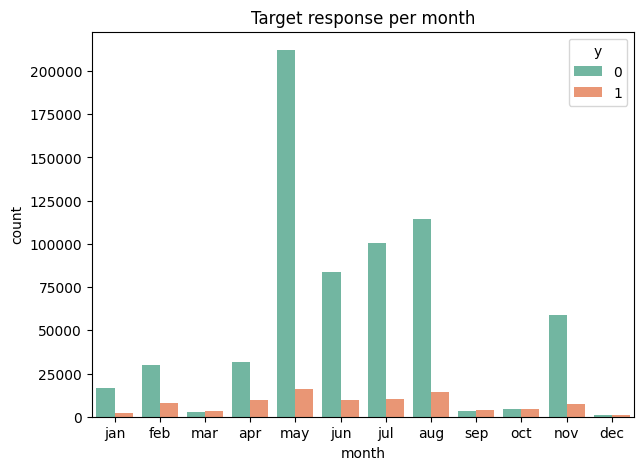

In [18]:
plt.figure(figsize=(7,5));

sns.countplot(x='month', hue='y', data=df, palette='Set2')
plt.title("Target response per month")
plt.show()

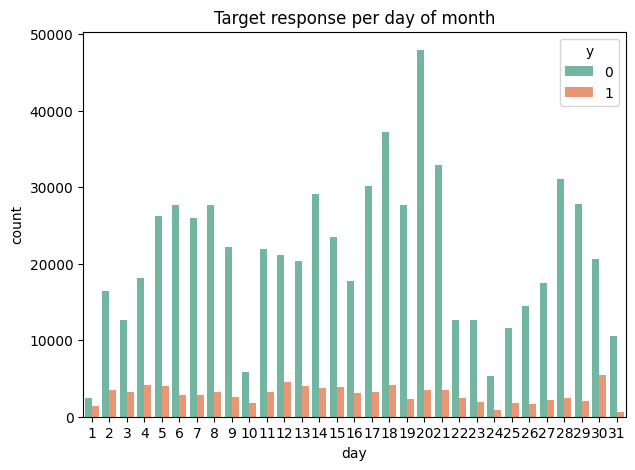

In [19]:
plt.figure(figsize=(7,5))

sns.countplot(x='day', hue='y', data=df, palette='Set2')
plt.title("Target response per day of month")
plt.show()

In [20]:
df['month'] = df['month'].cat.codes

## Feature engineering

Feature engineering consists of these steps:

**Transforms**
1) Log transform ```balance```. We will clip values at 0 since this column contains negative values.
2) Sine and cosine transform ```days``` and ```month```. 

**Generating new columns**
1) Convert ```pdays``` into a categorical column indicating whether a client was contacted or not.
2) Target and frequency encoding categorical columns.
3) Add binary columns for year-start, year-mid, and year-end.

In [21]:
df['log_balance'] = np.log1p(df['balance'].clip(0))

In [22]:
df['sin_day'] = np.sin(2*np.pi*df['day']/31)
df['cos_day'] = np.cos(2*np.pi*df['day']/31)

df['sin_month'] = np.sin(2*np.pi*df['month']/11)
df['cos_month'] = np.cos(2*np.pi*df['month']/11)

In [23]:
df['contacted_before'] = (df['pdays'] != -1).astype(int)

In [24]:
df['year_start'] = (df['month'] <= 3).astype(int)
df['year_mid'] = ((3 < df['month']) & (df['month'] <= 7)).astype(int)
df['year_end'] = (df['month'] > 7).astype(int)

In [25]:
job_freq = df['job'].value_counts()
df['job_count'] = df['job'].map(job_freq).fillna(0)
df.job_count

0         138107
1         170498
2         170498
3          11767
4         138107
           ...  
749995     64209
749996     35185
749997    170498
749998    138107
749999    138107
Name: job_count, Length: 750000, dtype: int64

In [26]:
convert_cat = ['poutcome','contact','loan','housing','default','education','marital']
for col in convert_cat:
    df[col] = pd.Categorical(df[col])

In [27]:
df.columns

Index(['id', 'age', 'job', 'marital', 'education', 'default', 'balance',
       'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign',
       'pdays', 'previous', 'poutcome', 'y', 'log_balance', 'sin_day',
       'cos_day', 'sin_month', 'cos_month', 'contacted_before', 'year_start',
       'year_mid', 'year_end', 'job_count'],
      dtype='object')

In [28]:
cats = ['contacted_before','year_start','year_mid','year_end','poutcome','contact','loan','housing','default','education','marital','job_count']
conts = ['age','log_balance','sin_day','cos_day','sin_month','cos_month','duration','campaign','previous']
dep = 'y'

Putting these preprocessing steps into a function:

In [29]:
def data_proc(df,cat_cols):
    for col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])
    
    month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
    df['month'] = df['month'].cat.codes
        
    df['log_balance'] = np.log1p(df['balance'].clip(0))
    df['contacted_before'] = (df['pdays'] != 1).astype(int)
    df['job_count'] = df['job'].map(df['job'].value_counts()).fillna(0)

    df['sin_day'] = np.sin(2*np.pi*df['day']/31)
    df['cos_day'] = np.cos(2*np.pi*df['day']/31)
    
    df['sin_month'] = np.sin(2*np.pi*df['month']/11)
    df['cos_month'] = np.cos(2*np.pi*df['month']/11)

    df['year_start'] = (df['month'] <= 3).astype(int)
    df['year_mid'] = ((3 < df['month']) & (df['month'] <= 7)).astype(int)
    df['year_end'] = (df['month'] > 7).astype(int)
    
    for col in cat_cols:
        df[col] = pd.Categorical(df[col])
        df[col] = df[col].cat.codes

## Set up the data

Split data into train and validation sets. Then, I converted the categorical columns to their numerical codes.

In [30]:
from sklearn.model_selection import train_test_split

trn_df,val_df = train_test_split(df, test_size=0.25)
trn_df[convert_cat] = trn_df[convert_cat].apply(lambda x: x.cat.codes)
val_df[convert_cat] = val_df[convert_cat].apply(lambda x: x.cat.codes)

In [31]:
def get_xs_y(df):
    xs = df[cats+conts].copy()
    y = df[dep].copy() if dep in df else None
    return xs,y

trn_indep,trn_dep = get_xs_y(trn_df)
val_indep,val_dep = get_xs_y(val_df)

In [32]:
print(f'train: {len(trn_dep)}; validation: {len(val_dep)}') 

train: 562500; validation: 187500


## Trying XGBoost

In [33]:
import xgboost as xgb

In [34]:
model = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=10,
    device='cuda',  # <== Enables GPU
    verbosity=1
)

In [35]:
model.fit(trn_indep,trn_dep)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [36]:
preds = model.predict(val_indep)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [03:46:06] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [37]:
from sklearn.metrics import roc_auc_score

roc_auc_score(val_dep,preds)

0.8210017035055391

## Submitting to Kaggle

In [38]:
tst_df = pd.read_csv(f'{path}/test.csv')
tst_df

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,999995,43,management,married,tertiary,no,0,yes,no,cellular,18,nov,65,2,-1,0,unknown
249996,999996,40,services,married,unknown,no,522,yes,no,cellular,19,nov,531,1,189,1,failure
249997,999997,63,retired,married,primary,no,33,no,no,cellular,3,jul,178,1,92,8,success
249998,999998,50,blue-collar,married,primary,no,2629,yes,no,unknown,30,may,163,2,-1,0,unknown


In [39]:
tst_df.isna().sum()

id           0
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64

In [40]:
data_proc(tst_df, convert_cat)

In [41]:
tst_indep,_ = get_xs_y(tst_df)

In [42]:
# function to create the submission csv
def subm(preds,suff):
    probs = preds[:,1]
    tst_df['y'] = probs
    sub_df = tst_df[['id','y']]
    sub_df.to_csv(f'sub_{suff}.csv', index=False)

In [43]:
subm(model.predict_proba(tst_indep), 'xgb4')

In [44]:
!head sub_xgb4.csv

id,y
750000,0.0011383975
750001,0.040519368
750002,2.758238e-06
750003,3.637404e-06
750004,0.001167092
750005,1.3533382e-05
750006,0.8820784
750007,0.1011343
750008,0.004805306
